# Cluster Cosmology: Data Vector

Here I first implement the computation of two important quantities for the data vector:
- $\left< \gamma_t (\theta) \right>$ : The `gamma_t` profile
- $\xi_{cc}(s) $: Cluster auto correlation function



In [ ]:
import hankl
print("Using hankel v{}".format(hankl.__version__))

In [ ]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.05)

omega_m  = cosmo.Om0
h=cosmo.H0.value/100.
const = 1.67e-7 * (omega_m * h**2) # /Mpc^2
rhom = const/6.01e-19  # Msun/Mpc^2

## Matter Power Spectrum: CAMB

We use CAMB to have a power spectrum as an example.

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from time import time

#Assume installed from github using "git clone --recursive https://github.com/cmbant/CAMB.git"
#This file is then in the docs folders
camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

### Get Matter power spectra for a given cosmology
Taken from notebook example: https://camb.readthedocs.io/en/latest/CAMBdemo.html

In [ ]:
zvec = np.linspace(0.2, 0.6, 10)

In [ ]:
#Now get matter power spectra and sigma8 at redshift 0 and 0.8
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.InitPower.set_params(ns=0.965)
#Note non-linear corrections couples to smaller scales than you want
pars.set_matter_power(redshifts=list(zvec), kmax=2.0)

#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh_lin, z_lin, pk_lin = results.get_matter_power_spectrum(minkh=3e-5, maxkh=1000, npoints = 1000)
s8 = np.array(results.get_sigma8())

#Non-Linear spectra (Halofit)
pars.NonLinear = model.NonLinear_both
results.calc_power_spectra(pars)
kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=3e-5, maxkh=1000, npoints = 1000)

In [ ]:
print(results.get_sigma8())

In [ ]:
for i, (redshift, line) in enumerate(zip(z_lin,['-','--'])):
    plt.loglog(kh_lin, pk_lin[i,:], color='k', ls = line)
    plt.loglog(kh_nonlin, pk_nonlin[i,:], color='r', ls = line)
plt.xlabel('k/h Mpc');
plt.ylabel(r'$P_{mm}(k)$')
plt.legend(['linear','non-linear'], loc='lower left');
# plt.title('Matter power at z=%s and z= %s'%tuple(z_lin));

# Cluster Tool Kit


In [ ]:
import cluster_toolkit as ct

omega_m = 0.3
Radii_bins = 100
R_perp_bins = 200
nz = 10
eTimes = dict()

r = np.logspace(-3., 2.5, Radii_bins)

In [ ]:
t0 = time()
Xi_2 = np.zeros((nz, Radii_bins))
for i in range(nz):
    s, xi2 = hankl.P2xi(kh_nonlin, pk_nonlin[i], l=0)
    Xi_2[i] = np.interp(r,s,xi2)
    
eTimes['Hankl'] = (time()-t0)*1000
print('It takes %.3f msec'%(eTimes['Hankl']))


In [ ]:
t0 = time()
dummy_concentration = 5.
Xi_2ct = np.zeros((nz, Radii_bins))
Sigma_2ct = np.zeros((nz, R_perp_bins))
for i in range(nz):
    xi_mm = ct.xi.xi_mm_at_r(r, kh_nonlin, pk_nonlin[i])
    Xi_2ct[i] = xi_mm

eTimes['ClusterToolKit'] = (time()-t0)*1000
print('It takes %.3f msec'%(eTimes['ClusterToolKit']))


In [ ]:
plt.figure(figsize=(8,5))
# plt.loglog()
plt.xscale('log')
plt.plot(r, r*r*Xi_2[0], label=r'Hankl - elapsed time: %.2f ms'%eTimes['Hankl'])
plt.plot(r, r*r*Xi_2ct[0], label=r'Cluster Tool Kit - elapsed time: %.2f ms'%eTimes['ClusterToolKit'])
plt.xlabel(r'$s\: (Mpc/h)$')
plt.ylabel(r'$s^{2} \xi_{l}$')
plt.legend()
plt.title('Hankel Transformation - Pk Non Linear')
plt.show()

# $\Delta \Sigma$, $\gamma$ profiles

In [ ]:
import astropy.units as u

In [ ]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.05)
omega_m  = cosmo.Om0
h=cosmo.H0.value/100.

const = 6.01e-19 # 4piG/c^2 [Mpc/Msun]
rhoc0 = cosmo.critical_density0.to(u.Msun/u.Mpc**3).value
rhom0 = rhoc0*omega_m

print('Rhoc: %.3e Msun/Mpc^3'%rhoc0)

## Halo Density Profiles: CCL

You can find here a very nice series of CCL tutorials
https://github.com/LSSTDESC/CCLX/blob/master/Halo%20profiles.ipynb

In [ ]:
import pyccl as ccl
cosmoc = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.83, n_s=0.96)

# Radius, wavenumber and mass
r_arr = np.geomspace(1E-3,1E2,256)
k_arr = np.geomspace(1E-3,1E2,256)
m_arr = np.geomspace(1E11,1E15,32)

# We will calculate everything at z=1 (scale factor = 0.5)
z = 0.1
a_sf = 1/(1+z)

# We will also use a mass definition with Delta = 200, and the Duffy 2008 concentration-mass relation
hmd_200c = ccl.halos.MassDef200c()
cM = ccl.halos.ConcentrationDuffy08(hmd_200c)

In [ ]:
profs = {}
profs['NFW'] = ccl.halos.HaloProfileNFW(cM, truncated=False)
profs['Einasto'] = ccl.halos.HaloProfileEinasto(cM, truncated=False)
profs['Hernquist'] = ccl.halos.HaloProfileHernquist(cM, truncated=False)

In [ ]:
# Plot the real-space profile for a fixed mass of M = 1E14 M_sun
plt.figure(figsize=(12,4.5))

plt.subplot(1,2,1)
for n,p in profs.items():
    rho_r = p.real(cosmoc, r_arr, 1E14, a_sf, mass_def=hmd_200c)
    plt.plot(r_arr, rho_r, label=n)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower left', fontsize=15)
plt.ylabel(r'$\rho(r)\,\,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$r\,\,[{\rm Mpc}]$', fontsize=15);

# Plot the Fourier-space profile for a fixed mass of M = 1E14 M_sun
plt.subplot(1,2,2)
for n,p in profs.items():
    rho_k = p.fourier(cosmoc, k_arr, 1E14, a_sf, mass_def=hmd_200c)
    plt.plot(k_arr, rho_k, label=n)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower left', fontsize=15)
plt.ylabel(r'$\rho(k)\,\,[M_\odot]$', fontsize=15)
plt.xlabel(r'$k\,\,[{\rm Mpc}^{-1}]$', fontsize=15);

## Cluster Power Spectrum 

In the case of cluster the contribution of the 1-halo term predominates over the 2-halo term up to $R_{vir}$.

$$
P_{cls}(k) = P_{1h}(k) + P_{2h}(k) 
$$

We already have the 2-halo term which is the non linear matter-matter power spectrum $P_{mm}(k)$. Now we will use `ccl` to have the 1-halo term in the fourier space.

In [353]:
def compute_cluster_power_spectrum(k_arr, z, mass, mass_def=hmd_200c, conc=cM):
    # scaling factor
    a_sf = 1/(1+z)
    
    # non linear matter power spectrum 
    pk_2h = ccl.nonlin_matter_power(cosmoc, k_arr, a_sf)
    
    # NFW profile
    profNFW = ccl.halos.HaloProfileNFW(conc, truncated=False)
    rho_nfw = profNFW.fourier(cosmoc, k_arr, mass, a_sf, mass_def=mass_def)
    
    # given xi=(rho_nfw - rhom)/rhom, rhom is a number, then after the hankel transformation is only a multplication factor
    # the hankel transformation of a constant is a dirac at k=0, i.e. 0
    pk_1h = (rho_nfw)/rhom0
    
    # total cluster power spectrum
    return pk_1h, pk_2h

Text(0.5, 1.0, 'Cluster Power Spectrum')

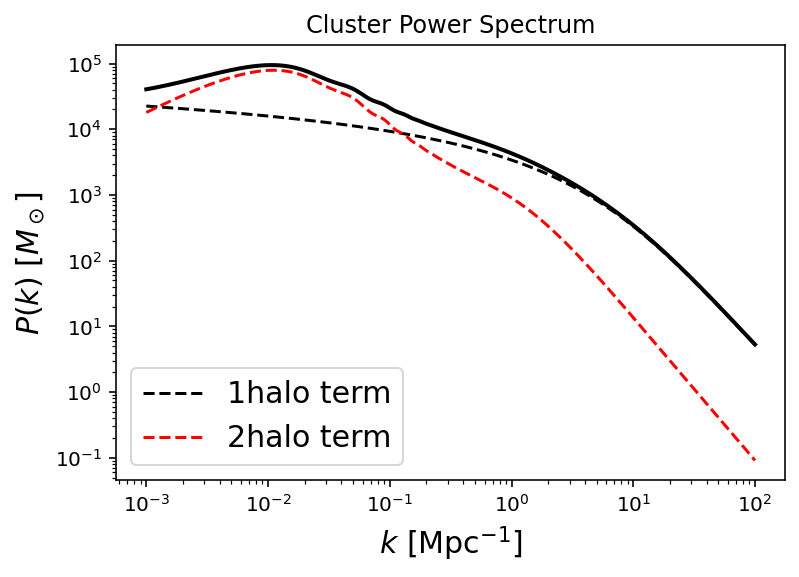

In [354]:
pk_1h, pk_2h = compute_cluster_power_spectrum(k_arr, 0.01, 1e14)

plt.plot(k_arr, pk_1h, 'k--', label='1halo term')
plt.plot(k_arr, pk_2h, 'r--', label='2halo term')
plt.plot(k_arr, pk_1h+pk_2h, 'k', lw=2)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower left', fontsize=15)
plt.ylabel(r'$P(k)\,\,[M_\odot]$', fontsize=15)
plt.xlabel(r'$k\,\,[{\rm Mpc}^{-1}]$', fontsize=15);
plt.title('Cluster Power Spectrum')

In [269]:
profNFW = ccl.halos.HaloProfileNFW(cM, truncated=False)

help(profNFW.shear)

Help on method shear in module pyccl.halos.profiles:

shear(cosmo, r, M, a_lens, a_source, mass_def=None) method of pyccl.halos.profiles.HaloProfileNFW instance
    Returns the shear (tangential) as a function of cosmology,
    radius, halo mass and the scale factors of the
    source and the lens.
    
    .. math::
       \gamma(R) = \frac{\Delta\Sigma(R)}{\Sigma_{\mathrm{crit}}} =
       \frac{\overline{\Sigma}(< R) -
       \Sigma(R)}{\Sigma_{\mathrm{crit}}},\
    
    where :math:`\overline{\Sigma}(< R)` is the average surface density
    within R.
    
    Args:
        cosmo (:class:`~pyccl.core.Cosmology`): A Cosmology object.
        r (float or array_like): comoving radius in Mpc.
        M (float or array_like): halo mass in units of M_sun.
        a_lens (float or array_like): lens' scale factor.
        a_source (float or array_like): source's scale factor.
        mass_def (:class:`~pyccl.halos.massdef.MassDef`):
            a mass definition object.
    
    Returns:
   

## Shear: Comparing Methods

`ccl` computes shear by the cumulative mass distribution.
$$
\gamma(R) = \frac{\Delta\Sigma(R)}{\Sigma_{\mathrm{crit}}} =
       \frac{\overline{\Sigma}(< R) -
       \Sigma(R)}{\Sigma_{\mathrm{crit}}},\
$$

We can also compute by the hankel transformation of the power spectrum:
$$
\gamma(R) \propto \frac{1}{2\pi^2} \int dk\, k\,
       P(k)\, j_2(k r)
$$

See Formula 12 from Jeong, Komatsu and Jain 2009

In [381]:
def compute_beta(zl, zs, cosmo):
    dl, ds = cosmo.angular_diameter_distance(np.array([zl, zs])).value
    dls = cosmo.angular_diameter_distance_z1z2(zl, zs).value
    return dl, dls/ds

def compute_sigma_crit_inv(z_lens, z_source, comso=cosmo):
    const = 6.01e-19
    
    # beta is dA_lens_source/dA_source
    dA_lens, beta = compute_beta(z_lens, z_source, cosmo)
    
    # final normalization factor
    sigma_crit_inv = const*(1+z_lens)*dA_lens*beta
    return sigma_crit_inv

def delta_sigma(k, P, l=2):
     # compute hankel transformation of the matter power spectrum
    r, f = hankl.FFTLog(k, P * k ** 0.5, q=0, mu=l + 0.5)
    _ds = f * (2.0 * np.pi) ** (-0.5) * r ** (-1.5)
    return r, _ds*rhom0

def avg_shear(k, P, l=2, z_lens=0., z_source_eff=1., cosmo=cosmo):
    """ Compute the averaged shear (gamma_t)
    
    Formula 12 from Jeong, Komatsu and Jain 2009
    """    
    # compute delta sigma
    r, dS = delta_sigma(k, P, l=2)
    
    # compute sigma_crit
    sigma_crit_inv = compute_sigma_crit_inv(z_lens, z_source_eff, cosmo)
    
    return r, dS*sigma_crit_inv

In [427]:
def compute_shear(r_arr, mass, z_lens, z_source, mass_def=hmd_200c, conc=cM):
    # scaling factor
    a_lens = 1/(1+z_lens)
    a_source = 1/(1+z_source)
    
    # wave number
    k_arr = np.logspace(-3.5, 3, 100) #2*np.pi/r_arr
    
    # non linear matter power spectrum 
    pk_2h = ccl.nonlin_matter_power(cosmoc, k_arr, a_lens)
    r2 , shear_2h = avg_shear(k_arr, pk_2h, z_lens=z_lens, z_source_eff=z_source, cosmo=cosmo)
    shear_2h = np.interp(r_arr, r2, shear_2h)
    
    # NFW profile
    profNFW = ccl.halos.HaloProfileNFW(conc, truncated=False)
    shear_nfw = profNFW.shear(cosmoc, r_arr, mass, a_lens, a_source, mass_def=mass_def)
    
    # 1halo term shear profile
    return shear_nfw+shear_2h

def compute_dsigma(r_arr, mass, z_lens, z_source, mass_def=hmd_200c, conc=cM):
    _shear = compute_shear(r_arr, mass, z_lens, z_source, mass_def=mass_def, conc=conc)
    sigma_crit_inv = compute_sigma_crit_inv(z_lens, z_source, cosmo)
    return _shear/sigam_crit_inv

In [431]:
mass = 1e14
t0 = time()
dSigma_2 = np.zeros((nz, Radii_bins))
dSigma_2b = np.zeros((nz, Radii_bins))
for i in range(nz):
    pk_1h, pk_2h = compute_cluster_power_spectrum(kh_nonlin, zvec[i], mass)
    pk_total = pk_1h+pk_2h
    s, DeltaSigma = delta_sigma(kh_nonlin, pk_total, l=2)
    dSigma_2[i] = np.interp(r, s, DeltaSigma)
    
eTimes['Hankl'] = (time()-t0)*1000
print('It takes %.3f msec'%(eTimes['Hankl']))


It takes 8.698 msec


In [432]:
mass = 1e14
t0 = time()
dSigma_2b = np.zeros((nz, Radii_bins))
for i in range(nz):
    dSigma_2b[i] = compute_dsigma(r, mass, zvec[i], 1.0, mass_def=hmd_200c, conc=cM)
    
eTimes['CCL'] = (time()-t0)*1000
print('It takes %.3f msec'%(eTimes['CCL']))


It takes 71.474 msec


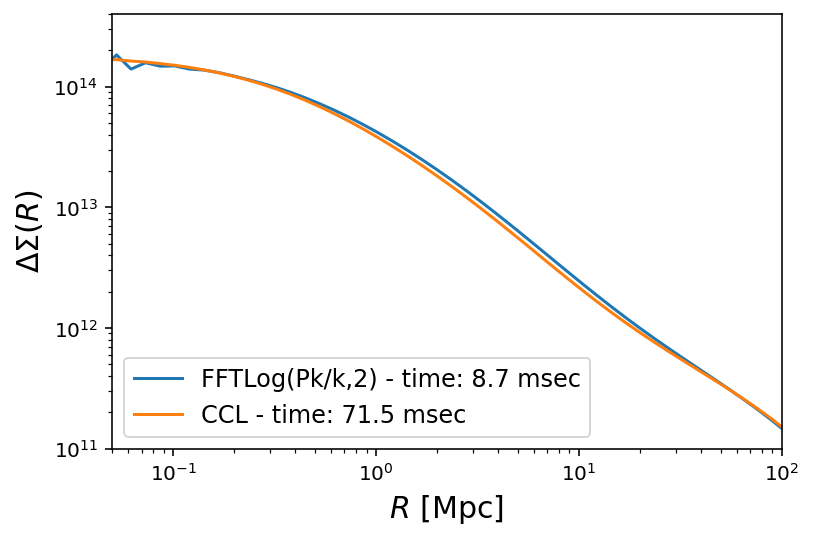

In [433]:
plt.loglog()
plt.plot(r, dSigma_2[0], label='FFTLog(Pk/k,2) - time: %.1f msec'%(eTimes['Hankl']))
plt.plot(r, dSigma_2b[0], label='CCL - time: %.1f msec'%(eTimes['CCL']))
# plt.plot(kh_nonlin, pk_2h)
# plt.plot(kh_nonlin, pk_total)
plt.legend(fontsize=12)
plt.xlim(5e-2, 1e2)
plt.ylim(1e11, 4e14)
plt.ylabel(r'$\Delta \Sigma (R)$', fontsize=15)
plt.xlabel(r'$R\,\,[{\rm Mpc}]$', fontsize=15);


In [435]:
mass = 1e14
t0 = time()
dSigma_2 = np.zeros((nz, Radii_bins))
dSigma_2b = np.zeros((nz, Radii_bins))
for i in range(nz):
    pk_1h, pk_2h = compute_cluster_power_spectrum(kh_nonlin, zvec[i], mass)
    pk_total = pk_1h+pk_2h
    s, DeltaSigma = avg_shear(kh_nonlin, pk_total, z_lens=zvec[i], l=2)
    dSigma_2[i] = np.interp(r, s, DeltaSigma)
    
eTimes['Hankl'] = (time()-t0)*1000
print('It takes %.3f msec'%(eTimes['Hankl']))


It takes 11.527 msec


In [436]:
mass = 1e14
t0 = time()
dSigma_2b = np.zeros((nz, Radii_bins))
for i in range(nz):
    dSigma_2b[i] = compute_shear(r, mass, zvec[i], 1.0, mass_def=hmd_200c, conc=cM)
    
eTimes['CCL'] = (time()-t0)*1000
print('It takes %.3f msec'%(eTimes['CCL']))


It takes 75.085 msec


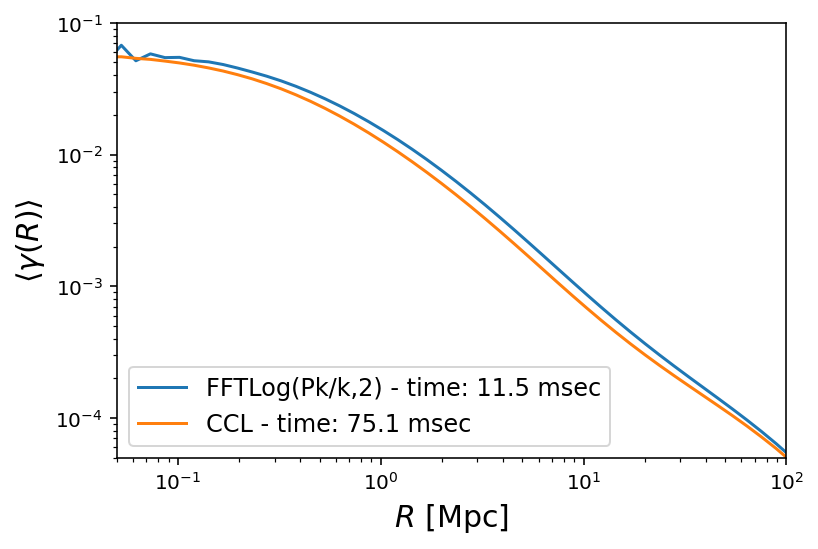

In [444]:
plt.loglog()
plt.plot(r, dSigma_2[0], label='FFTLog(Pk/k,2) - time: %.1f msec'%(eTimes['Hankl']))
plt.plot(r, dSigma_2b[0], label='CCL - time: %.1f msec'%(eTimes['CCL']))
# plt.plot(kh_nonlin, pk_2h)
# plt.plot(kh_nonlin, pk_total)
plt.legend(fontsize=12)
plt.xlim(5e-2, 1e2)
plt.ylim(5e-5, 1e-1)
plt.ylabel(r'$\left< \gamma (R) \right>$', fontsize=15)
plt.xlabel(r'$R\,\,[{\rm Mpc}]$', fontsize=15);
